# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


**Описание данных**

Признаки

*	`DateCrawled` — дата скачивания анкеты из базы;
*	`VehicleType` — тип автомобильного кузова;
*	`RegistrationYear` — год регистрации автомобиля;
*	`Gearbox` — тип коробки передач;
*	`Power` — мощность (л. с.);
*	`Model` — модель автомобиля;
*	`Kilometer` — пробег (км);
*	`RegistrationMonth` — месяц регистрации автомобиля;
*	`FuelType` — тип топлива;
*	`Brand` — марка автомобиля;
*	`NotRepaired` — была машина в ремонте или нет;
*	`DateCreated` — дата создания анкеты;
*	`NumberOfPictures` — количество фотографий автомобиля;
*	`PostalCode` — почтовый индекс владельца анкеты (пользователя);
*	`LastSeen` — дата последней активности пользователя.

Целевой признак

* `Price` — цена (евро)


## Подготовка данных

!pip install lightgbm

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn

from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import warnings

warnings.simplefilter('ignore')
pd.set_option('display.max_columns', None)

In [2]:
try:
    df = pd.read_csv('/datasets/autos.csv')    
except FileNotFoundError:
    df = pd.read_csv('autos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
df.isnull().sum().sort_values(ascending=False) / df.shape[0] * 100  # процент пропусков в наборе данных по столбцам

NotRepaired          20.079070
VehicleType          10.579368
FuelType              9.282697
Gearbox               5.596709
Model                 5.560588
DateCrawled           0.000000
Price                 0.000000
RegistrationYear      0.000000
Power                 0.000000
Kilometer             0.000000
RegistrationMonth     0.000000
Brand                 0.000000
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

Первые выводы о данных:

* В столбцах `Model`,`GearBox`,`FuelType`,`VehicleType`,`NotRepaired` присутсвуют пропуски;
* Имена столбцов требуется привести в змеиному стилю;
* Столбцы с датами привести к типу DateTime;
* Столбец `NumberOfPictures` весь нулевой. Выглядит как ошибка при выгрузке данных, не представляю как можно выбирать автомобиль без фото, придется удалить;
* Нулевые значения в целевом столбце `Price` скорее всего придется удалить, посмотрим на их количество;
* Год регистрации `RegistrationYear` со значениями 1000 и 9999 тоже настораживает;
* Мощность двигателя `Power` в 20000 л.с. для атомобиля? Может там объявление о продаже теплохода?
* Пробег `Kilometer` выглядит правдоподобно, но смущает распределение квартилей больше половины значений ровно 150 000 км, может это максимум который допускает указывать сервис? 
* Месяц регистрации `RegistrationMonth` с нулевым значением тоже не верные значения;
* Столбцы `DateCrawled`, `DateCreated`, `LastSeen` можно будет удалить, данные из этих столбцов не потребуются для обучения моделей.

Сменим названия столбцов

In [7]:
df.columns.to_list()

['DateCrawled',
 'Price',
 'VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Kilometer',
 'RegistrationMonth',
 'FuelType',
 'Brand',
 'NotRepaired',
 'DateCreated',
 'NumberOfPictures',
 'PostalCode',
 'LastSeen']

In [8]:
# новые названия
cols_name = ['date_crawled',
 'price',
 'vehicle_type',
 'registration_year',
 'gear_box',
 'power',
 'model',
 'kilometer',
 'registration_month',
 'fuel_type',
 'brand',
 'not_repaired',
 'date_created',
 'number_of_pictures',
 'postal_code',
 'last_seen']
df = df.set_axis(cols_name, axis='columns') # меняем названия

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gear_box            334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Посмотрим на количество явных дубликатов

In [10]:
df.duplicated().sum()

4

In [11]:
df[df.duplicated(keep=False)].sort_values(by='date_crawled', ascending=False)

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57


Удалим дубликаты

In [12]:
df = df.drop_duplicates()
df.duplicated().sum()

0

Удалим столбцец `number_of_pictures`

In [13]:
df = df.drop('number_of_pictures', axis=1)

Приведем столбцы с датой к типу DateTime

In [14]:
df[['date_crawled', 'date_created', 'last_seen']] = df[['date_crawled', 'date_created', 'last_seen']].apply(pd.to_datetime)

In [15]:
df['date_created'].sort_values()

61207    2014-03-10
4001     2015-03-20
342275   2015-06-18
86601    2015-08-07
175103   2015-08-10
            ...    
184411   2016-04-07
262340   2016-04-07
214462   2016-04-07
241969   2016-04-07
260600   2016-04-07
Name: date_created, Length: 354365, dtype: datetime64[ns]

Самая поздняя дата создания объявления апрель 2016 года.



#### Начнем с целевого столбца - цена `price`

Посмотрим сколько нулевых значений в столбце с ценой

In [16]:
df[df['price'] == 0]['price'].count()/ df.shape[0] * 100

3.0398035923412303

Примерно 3 %, чем заполнять такие нули не понятно, к тому же это столбце целевого признака, нули там нам точно не нужны. Посмотрим на распределение цены!

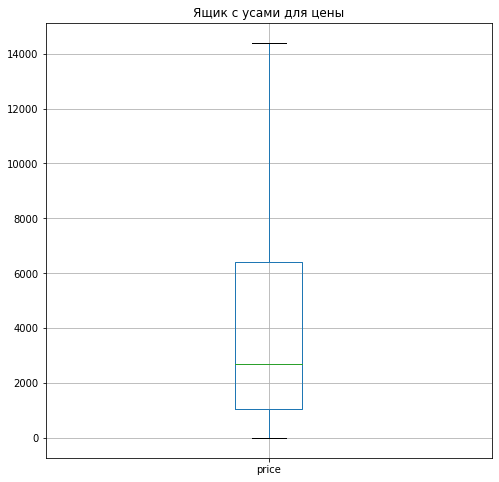

In [17]:
df.boxplot(['price'], figsize=(8,8), showfliers=False)
plt.title('Ящик с усами для цены')
plt.show()

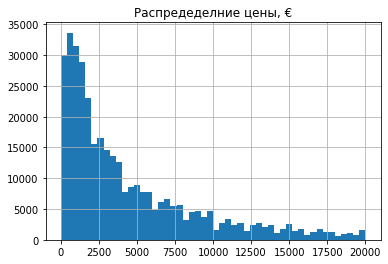

In [18]:
df['price'].hist(bins=50)
plt.title('Распредеделние цены, €')
plt.show()

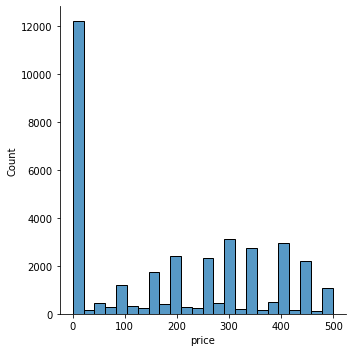

In [19]:
sns.displot(df[df['price']<500]['price'])

предлагаю значения цены ниже 50 удалить

In [20]:
df[df['price'] < 50]['price'].count()/ df.shape[0] * 100

3.505707392095721

In [21]:
df = df.drop(df.query('price<50').index)

#### Год регистрации `RegistrationYear`

Посмотрим на разброс значений

In [22]:
df['registration_year'].sort_values()

244092    1000
110123    1000
183779    1000
213499    1000
135865    1000
          ... 
149151    9999
50141     9999
62395     9999
17271     9999
257793    9999
Name: registration_year, Length: 341942, dtype: int64

Последняя дата создания объявления апрель 2016 года, посмотрим сколько значений больше 2016 года

In [23]:
df[df['registration_year'] > 2016]

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,31139,2016-03-16 09:16:46
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07,66115,2016-03-07 18:57:08
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10,33397,2016-03-25 10:17:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354112,2016-03-11 15:49:51,3600,NaN,2017,manual,86,transit,150000,5,gasoline,ford,NaN,2016-03-11,32339,2016-03-12 05:45:02
354140,2016-03-29 16:47:29,1000,NaN,2017,manual,101,a4,150000,9,NaN,audi,NaN,2016-03-29,38315,2016-04-06 02:44:27
354203,2016-03-17 00:56:26,2140,NaN,2018,manual,80,fiesta,150000,6,NaN,ford,no,2016-03-17,44866,2016-03-29 15:45:04
354253,2016-03-25 09:37:59,1250,NaN,2018,NaN,0,corsa,150000,0,petrol,opel,NaN,2016-03-25,45527,2016-04-06 07:46:13


In [24]:
df[df['registration_year'] > 2016]['registration_year'].count() / df.shape[0] * 100

4.007697211807851

Значений очень много, 4 %. Есть как значения с реальными годами 2017, 2018, 2019 а дальше значения идут не реальные. Посмотрим сколько строк с нереальными датами. Посмотрим какие даты встречаются в наборе

In [25]:
df['registration_year'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1234, 1255, 1300, 1400, 1500, 1600, 1602,
       1800, 1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222,
       2290, 2500, 2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500,
       4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 7000, 7100, 7800,
       8000, 8200, 8500, 8888, 9000, 9450, 9999])

Начало эры автомобилестроения конец XIX - начало XX веков. Так что думаю строки с годом публикации меньше 1970 и больше 2019 можно удалить, посмотрми сколько таких строк

In [26]:
df.query('registration_year<1970 or registration_year>2019')['registration_year'].count() / df.shape[0] * 100 

0.3541536283931193

Записей совсем мало - удалим

In [27]:
df = df.drop(df.query('registration_year<1910 or registration_year>2019').index)

#### Мощность двигателя `Power`

In [28]:
df['power'].sort_values()

0             0
154303        0
154301        0
154288        0
154280        0
          ...  
63986     17932
132485    19208
114106    19211
299180    19312
219584    20000
Name: power, Length: 341815, dtype: int64

Есть нулевые значения и аномально высокие

<AxesSubplot:xlabel='power'>

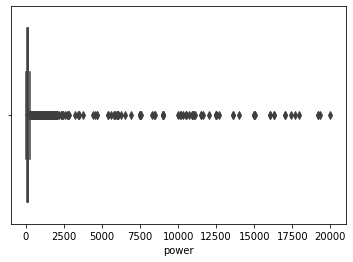

In [29]:
sns.boxplot(x=(df['power']))

In [30]:
df['brand'].value_counts()

volkswagen        74059
opel              38315
bmw               35585
mercedes_benz     31207
audi              28438
ford              24353
renault           17315
peugeot           10741
fiat               9295
seat               6696
mazda              5445
skoda              5429
smart              5151
citroen            4999
nissan             4791
toyota             4526
hyundai            3523
mini               3160
volvo              3111
mitsubishi         2912
honda              2704
sonstige_autos     2702
kia                2403
suzuki             2269
alfa_romeo         2215
chevrolet          1700
chrysler           1359
dacia               888
daihatsu            773
subaru              726
porsche             708
jeep                653
land_rover          533
daewoo              530
saab                512
jaguar              488
trabant             478
rover               458
lancia              452
lada                213
Name: brand, dtype: int64

В нашем наборе нет марок автомобилей производителей суперкаров - Ferrari, Bugatti, Lamborgini  и т.д. Поэтому думаю все что выше 600 лошадинных сил, явно ошибочные данные. Посмотрим

In [31]:
df[df['power'] > 600]['power'].sort_values().unique()

array([  601,   602,   603,   604,   606,   607,   610,   612,   620,
         640,   645,   650,   651,   671,   678,   682,   685,   696,
         700,   702,   703,   732,   743,   750,   751,   754,   771,
         776,   800,   805,   808,   850,   851,   871,   900,   901,
         902,   903,   907,   909,   923,   950,   952,   953,   998,
         999,  1000,  1001,  1002,  1003,  1004,  1005,  1011,  1012,
        1016,  1017,  1021,  1024,  1054,  1055,  1056,  1062,  1079,
        1082,  1090,  1100,  1103,  1105,  1115,  1120,  1149,  1151,
        1158,  1160,  1162,  1164,  1199,  1200,  1202,  1221,  1223,
        1230,  1239,  1240,  1241,  1250,  1252,  1256,  1275,  1288,
        1299,  1300,  1312,  1317,  1324,  1339,  1351,  1360,  1362,
        1363,  1367,  1390,  1394,  1398,  1399,  1400,  1401,  1403,
        1405,  1416,  1432,  1433,  1436,  1500,  1501,  1502,  1503,
        1506,  1521,  1548,  1595,  1596,  1597,  1598,  1600,  1625,
        1631,  1653,

Удалим эти записи 

In [32]:
df = df.drop(df.query('power > 600').index)

Посмотрим сколько строк с нулевой мощностью

In [33]:
df[df['power'] == 0]['brand'].count()

35438

Таких значений очень много, менять нули будем на значения медианы по модели, марке и году выпуска. Сделаем это после заполнения пропусков.

### Заполнение пропусков


In [34]:
df.isnull().sum().sort_values(ascending=False) / df.shape[0] * 100

not_repaired          18.926335
vehicle_type           9.606227
fuel_type              8.360422
model                  4.999326
gear_box               4.845578
date_crawled           0.000000
price                  0.000000
registration_year      0.000000
power                  0.000000
kilometer              0.000000
registration_month     0.000000
brand                  0.000000
date_created           0.000000
postal_code            0.000000
last_seen              0.000000
dtype: float64

#### Столбец `not_repaired`


In [35]:
df['not_repaired'].isnull().sum()

64627

<AxesSubplot:xlabel='not_repaired', ylabel='count'>

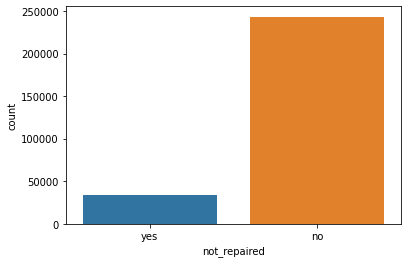

In [36]:
sns.countplot(df['not_repaired'])

Как-то заменить пропуски на был ремонт или нет, основываясь на других столбцах не получится. Предлагаю пропуски заменить на значение `other`

In [37]:
df['not_repaired'] = df['not_repaired'].fillna('other')

<AxesSubplot:xlabel='not_repaired', ylabel='count'>

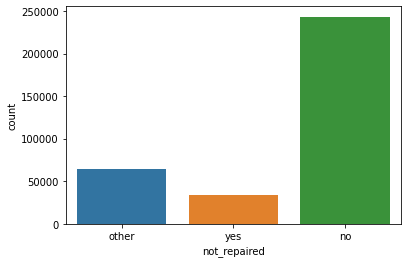

In [38]:
sns.countplot(df['not_repaired'])

#### Тип кузова `vehicle_type`

<AxesSubplot:xlabel='vehicle_type', ylabel='count'>

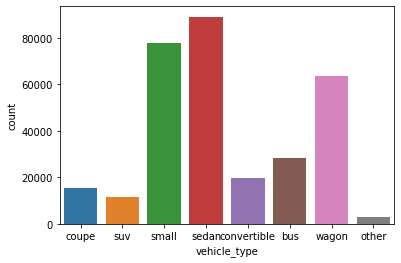

In [39]:
sns.countplot(df['vehicle_type'])

In [40]:
df['vehicle_type'].isnull().sum()

32802

Распределение кузовов выглядит правдоподобно. Пропуски заменим на `other`

In [41]:
df['vehicle_type'] = df['vehicle_type'].fillna('other')

<AxesSubplot:xlabel='vehicle_type', ylabel='count'>

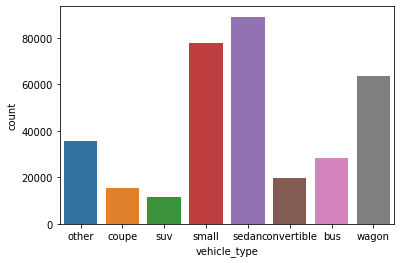

In [42]:
sns.countplot(df['vehicle_type'])

#### Тип кузова `fuel_type`

<AxesSubplot:xlabel='fuel_type', ylabel='count'>

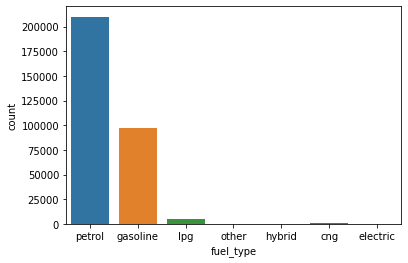

In [43]:
sns.countplot(df['fuel_type'])

In [44]:
df['fuel_type'].isnull().sum()

28548

Пропуски заменим на `other`

In [45]:
df['fuel_type'] = df['fuel_type'].fillna('other')

Petrol и gasoline это одно и тоже - бензин, объединим в одно

In [46]:
df['fuel_type'] = df['fuel_type'].replace('gasoline', 'petrol')

<AxesSubplot:xlabel='fuel_type', ylabel='count'>

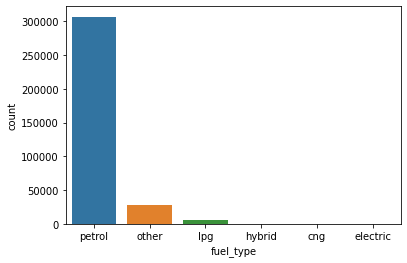

In [47]:
sns.countplot(df['fuel_type'])

#### Коробка передач `gear_box`

<AxesSubplot:xlabel='gear_box', ylabel='count'>

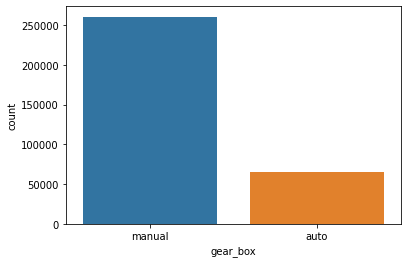

In [48]:
sns.countplot(df['gear_box'])

In [49]:
df['gear_box'].isnull().sum()

16546

#### Коробка передач `model`

In [50]:
df['model'].isnull().sum()

17071

In [51]:
df.isnull().sum().sort_values(ascending=False) / df.shape[0] * 100

model                 4.999326
gear_box              4.845578
date_crawled          0.000000
price                 0.000000
vehicle_type          0.000000
registration_year     0.000000
power                 0.000000
kilometer             0.000000
registration_month    0.000000
fuel_type             0.000000
brand                 0.000000
not_repaired          0.000000
date_created          0.000000
postal_code           0.000000
last_seen             0.000000
dtype: float64

Пропуски в столбцах с коробкой передач и моделью заполним медианой после перевода категориальных признаков с помощью LabelEncoding. Выделим индексы с пропусками в столбцах и без них.

In [52]:
model_index_nan = df.query('model!=model')['model'].index
model_index = df.query('model==model')['model'].index

gear_box_index_nan = df.query('gear_box!=gear_box')['gear_box'].index
gear_box_index = df.query('gear_box==gear_box')['gear_box'].index

In [53]:
encoder = LabelEncoder()

In [54]:
df.loc[model_index,'model'] = encoder.fit_transform(df.loc[model_index,'model'])
df.loc[gear_box_index,'gear_box'] = encoder.fit_transform(df.loc[gear_box_index,'gear_box'])

df['fuel_type'] = encoder.fit_transform(df['fuel_type'])
df['brand'] = encoder.fit_transform(df['brand'])
df['not_repaired'] = encoder.fit_transform(df['not_repaired'])
df['vehicle_type'] = encoder.fit_transform(df['vehicle_type'])

In [55]:
df.head(5)

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
0,2016-03-24 11:52:17,480,3,1993,1,0,116,150000,0,5,38,1,2016-03-24,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,2,2011,1,190,NaN,125000,5,5,1,2,2016-03-24,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,6,2004,0,163,117,125000,8,5,14,1,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,5,2001,1,75,116,150000,6,5,38,0,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,5,2008,1,69,101,90000,7,5,31,0,2016-03-31,60437,2016-04-06 10:17:21


Для замены пропусков будем использовать функцию, которая вычисляет медиану по сгруппированному по столбцам набору данных и меняет пропуски на медиану

In [56]:
def replace_nan(df,col,cols,index,key='nan'):
    if key == 'nan':
        median = df.groupby(cols)[col].apply(lambda x: x.fillna(x.median()))
    elif key == 'zero':
        median = df.groupby(cols)[col].apply(lambda x: x.replace(0,x.median()))
    df.loc[index,col] = median.loc[index]
    return df

Модель заполним по марке, мощности и году выпуска.

In [57]:
df = replace_nan(df,'model',['brand','power','registration_year'],model_index_nan)

In [58]:
df[['model','gear_box']].isnull().sum().sort_values(ascending=False) / df.shape[0] * 100

gear_box    4.845578
model       1.109627
dtype: float64

Попробуем заполнить оставшиеся пропуски по двум столбцам.

In [59]:
model_index_nan = df.query('model!=model')['model'].index
gear_box_index_nan = df.query('gear_box!=gear_box')['gear_box'].index

In [60]:
df = replace_nan(df,'model',['brand','registration_year'],model_index_nan)
df = replace_nan(df,'gear_box',['brand','registration_year'],gear_box_index_nan)

In [61]:
df[['model','gear_box']].isnull().sum().sort_values(ascending=False) / df.shape[0] * 100

model       0.798030
gear_box    0.023136
dtype: float64

Осталось совсем немного пропусков, думаю можно удалить.

In [62]:
index_nan = df.query('model!=model or gear_box!=gear_box').index

In [63]:
df = df.drop(index_nan)

In [64]:
df.shape

(338673, 15)

In [65]:
df.isnull().sum().sort_values(ascending=False) / df.shape[0] * 100

date_crawled          0.0
price                 0.0
vehicle_type          0.0
registration_year     0.0
gear_box              0.0
power                 0.0
model                 0.0
kilometer             0.0
registration_month    0.0
fuel_type             0.0
brand                 0.0
not_repaired          0.0
date_created          0.0
postal_code           0.0
last_seen             0.0
dtype: float64

С пропусками разобрались, заодно преобразовали категориальные признаки.

### Количественные признаки
Перейдем к работе с количественными признаками



In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338673 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        338673 non-null  datetime64[ns]
 1   price               338673 non-null  int64         
 2   vehicle_type        338673 non-null  int64         
 3   registration_year   338673 non-null  int64         
 4   gear_box            338673 non-null  object        
 5   power               338673 non-null  int64         
 6   model               338673 non-null  object        
 7   kilometer           338673 non-null  int64         
 8   registration_month  338673 non-null  int64         
 9   fuel_type           338673 non-null  int64         
 10  brand               338673 non-null  int64         
 11  not_repaired        338673 non-null  int64         
 12  date_created        338673 non-null  datetime64[ns]
 13  postal_code         338673 no

In [67]:
df[['power','kilometer','registration_month']].describe()

,power,kilometer,registration_month
count,338673.000000,338673.000000,338673.000000
mean,107.792484,128794.604235,5.800740
std,62.278809,36915.272843,3.689429
min,0.000000,5000.000000,0.000000
25%,70.000000,125000.000000,3.000000
50%,105.000000,150000.000000,6.000000
75%,143.000000,150000.000000,9.000000
max,600.000000,150000.000000,12.000000


#### Мощность двигателя `Power`

Посмотрим сколько строк с нулевой мощностью, осталось

In [68]:
df[df['power'] == 0]['brand'].count()

34556

Заполним медианой по модели, марке и году выпуска

In [69]:
power_zero_index = df[df['power'] == 0].index
df = replace_nan(df,'power',['brand','registration_year','model'],power_zero_index,'zero')

Теперь попробуем только по модели и году выпуска, а потом по модели и типу топлива

In [70]:
df = replace_nan(df,'power',['registration_year','model'],power_zero_index,'zero')
df = replace_nan(df,'power',['fuel_type','model'],power_zero_index,'zero')

In [71]:
df[df['power'] == 0]['brand'].count()

117

Осталось 117 нулевых значений, можно удалить

In [72]:
df = df.drop(df.query('power == 0').index)

#### Пробег `kilometer`

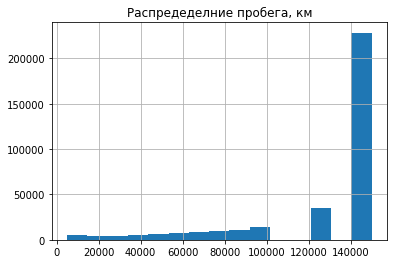

In [73]:
df['kilometer'].hist(bins=15)
plt.title('Распредеделние пробега, км')
plt.show()

У пробега подозрительно, только что максимальный пробег ограничен 150 000 км, и при этом таких объявлений подавляющее большинство.

#### Месяц регистрации `registration_month`

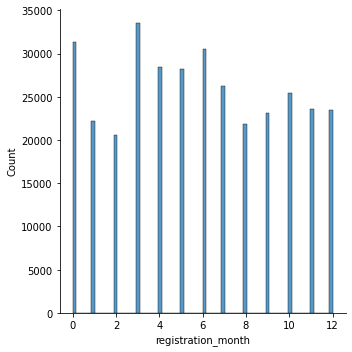

In [74]:
sns.displot(df['registration_month'])

In [75]:
df[df['registration_month']==0]['registration_month'].count()

31326

По месяцам регистрации выбивается только нулевое значение. Видимо при выгрузке ошибка возникла или при заполнении объявления человеком не был указан месяц.

Эти записи распределим равномерно по 12 месяцам, с учетом доли по месяцам. 

In [76]:
month_list = []
for i in range(1,13):
    num = df.query('registration_month == @i').shape[0]/(df.shape[0]-df.query('registration_month == 0').shape[0])
    num_size = round(df.query('registration_month == 0').shape[0]*num)
    month_list.append(num_size)

In [77]:
sum(month_list)

31326

In [78]:
month_list

[2266, 2100, 3416, 2898, 2881, 3107, 2674, 2233, 2359, 2592, 2403, 2397]

Столько записей с нулем в месяце отнесем к каждому из 12 месяцем

In [79]:
month_zero_index = df.query('registration_month==0').index # список индексов с нулями в столбце с месяцем
for i, n in enumerate(month_list):  
    index_month = np.random.choice(month_zero_index,size = n,replace=False) 
    df.loc[index_month,'registration_month'] = i+1
    month_zero_index = month_zero_index[~np.isin(month_zero_index, index_month)]

In [80]:
df[df['registration_month']==0]['registration_month'].count()

0

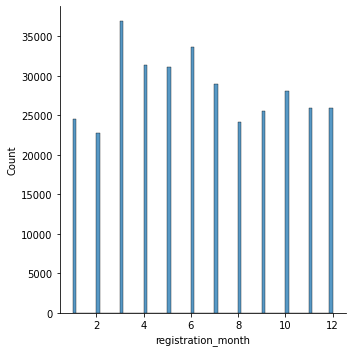

In [81]:
sns.displot(df['registration_month'])

Нули в месяце заменили. 

Проверим теперь что в итоге получили

In [82]:
df.head(5)

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
0,2016-03-24 11:52:17,480,3,1993,1,75.0,116,150000,1,5,38,1,2016-03-24,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,2,2011,1,190.0,31.0,125000,5,5,1,2,2016-03-24,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,6,2004,0,163.0,117,125000,8,5,14,1,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,5,2001,1,75.0,116,150000,6,5,38,0,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,5,2008,1,69.0,101,90000,7,5,31,0,2016-03-31,60437,2016-04-06 10:17:21


In [83]:
df.describe()

,price,vehicle_type,registration_year,power,kilometer,registration_month,fuel_type,brand,not_repaired,postal_code
count,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000
mean,4566.517040,4.158875,2003.282323,117.729904,128795.723603,6.393400,4.877199,20.778007,0.385936,50720.319232
std,4504.413595,2.036970,7.100662,52.705652,36912.243136,3.348671,0.418437,13.299304,0.659354,25722.528430
min,50.000000,0.000000,1910.000000,0.500000,5000.000000,1.000000,0.000000,0.000000,0.000000,1067.000000
25%,1200.000000,3.000000,1999.000000,75.000000,125000.000000,4.000000,5.000000,9.000000,0.000000,30455.000000
50%,2900.000000,4.000000,2003.000000,109.000000,150000.000000,6.000000,5.000000,24.000000,0.000000,49545.000000
75%,6500.000000,5.000000,2008.000000,143.000000,150000.000000,9.000000,5.000000,34.000000,1.000000,71254.000000
max,20000.000000,7.000000,2019.000000,600.000000,150000.000000,12.000000,5.000000,39.000000,2.000000,99998.000000


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338556 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        338556 non-null  datetime64[ns]
 1   price               338556 non-null  int64         
 2   vehicle_type        338556 non-null  int64         
 3   registration_year   338556 non-null  int64         
 4   gear_box            338556 non-null  object        
 5   power               338556 non-null  float64       
 6   model               338556 non-null  object        
 7   kilometer           338556 non-null  int64         
 8   registration_month  338556 non-null  int64         
 9   fuel_type           338556 non-null  int64         
 10  brand               338556 non-null  int64         
 11  not_repaired        338556 non-null  int64         
 12  date_created        338556 non-null  datetime64[ns]
 13  postal_code         338556 no

In [85]:
df.duplicated().sum()

0

Сменим тип данных у столбцов `gear_box`, `model` на int32

In [86]:
df = df.astype({'gear_box':'int32','model': 'int32'})

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338556 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        338556 non-null  datetime64[ns]
 1   price               338556 non-null  int64         
 2   vehicle_type        338556 non-null  int64         
 3   registration_year   338556 non-null  int64         
 4   gear_box            338556 non-null  int32         
 5   power               338556 non-null  float64       
 6   model               338556 non-null  int32         
 7   kilometer           338556 non-null  int64         
 8   registration_month  338556 non-null  int64         
 9   fuel_type           338556 non-null  int64         
 10  brand               338556 non-null  int64         
 11  not_repaired        338556 non-null  int64         
 12  date_created        338556 non-null  datetime64[ns]
 13  postal_code         338556 no

Предобработку данных на этом можно закончить

## Обучение моделей

### Подготовка признаков

Поделим исходный датасет на признаки и таргет 

In [88]:
X = df.drop(['date_crawled','date_created','last_seen','price','postal_code','registration_month'],axis=1)
y = df['price']

In [89]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 314)

Для обучения моделей и предсказания результатов с подсчетом затрачиваемого времени, будем использовать следующие функции

In [90]:
def learn_model(model,x_train,y_train):
    start = time.time()
    model.fit(x_train,y_train)
    end = time.time()
    return model, end - start

def predict_model(model,x_test,y_test):
    start = time.time()
    pred = model.predict(x_test)
    end = time.time()
    rmse = mean_squared_error(y_test,pred,squared=False)
    return end - start, rmse

In [91]:
compare_models = pd.DataFrame(columns=['Learning time','Predict time','RMSE'])

In [92]:
def add_model(learn_time,pred_time,rmse,model_name,df): #функция для добавления строчки 
    df.loc[model_name,'RMSE'] = rmse
    df.loc[model_name,'Learning time'] = learn_time
    df.loc[model_name,'Predict time'] = pred_time

In [93]:
def learn_model(model,x_train,y_train):
    start = time.time()
    model.fit(x_train,y_train)
    end = time.time()
    return model, end - start

def predict_model(model,x_test,y_test):
    start = time.time()
    pred = model.predict(x_test)
    end = time.time()
    rmse = mean_squared_error(y_test,pred,squared=False)
    return end - start, rmse

In [94]:
compare_models = pd.DataFrame(columns=['Learning time','Predict time','RMSE'])

In [95]:
def add_model(learn_time,pred_time,rmse,model_name,df): #функция для добавления строчки 
    df.loc[model_name,'RMSE'] = rmse
    df.loc[model_name,'Learning time'] = learn_time
    df.loc[model_name,'Predict time'] = pred_time

### Модели ML

#### Линейная регрессия

In [96]:
linear_regression_model, linear_regression_time_learn = learn_model(LinearRegression(),x_train,y_train)
linear_regression_time_pred, linear_regression_rmse = predict_model(linear_regression_model,x_test,y_test)

In [97]:
linear_regression_rmse

3053.9935297240045

In [98]:
add_model(linear_regression_time_learn,linear_regression_time_pred,linear_regression_rmse,'Linear regression',compare_models)

#### ElasticNet

In [99]:
elastic_net_model, elastic_net_time_learn = learn_model(ElasticNet(random_state = 314),x_train,y_train)
elastic_net_time_pred, elastic_net_rmse = predict_model(elastic_net_model,x_test,y_test)

In [100]:
elastic_net_rmse

3090.850213336822

Попробуем с помощью GridSearch подобрать гиперпараметры для модели ElasticNet что бы добиться лучшего значения метрики

In [101]:
%%time
param_grid_en = [{'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 ,1], 'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5]}]
en = ElasticNet()
grid_search_en = GridSearchCV(en, param_grid_en, cv=5, scoring='neg_root_mean_squared_error', refit=True)
grid_search_en.fit(X, y)
grid_search_en.best_params_

CPU times: user 1min 4s, sys: 15.2 s, total: 1min 19s
Wall time: 34.7 s


{'alpha': 0.1, 'l1_ratio': 0.5}

In [102]:
grid_search_en.best_score_

-3059.4640800404572

In [103]:
elastic_net_gs_model, elastic_net_gs_time_learn = learn_model(ElasticNet(random_state = 314, alpha=0.1, l1_ratio=0.5),x_train,y_train)
elastic_net_gs_time_pred, elastic_net_gs_rmse = predict_model(elastic_net_gs_model,x_test,y_test)

In [104]:
elastic_net_gs_rmse

3056.173663561671

In [105]:
add_model(elastic_net_gs_time_learn,elastic_net_gs_time_pred,elastic_net_gs_rmse,'Elastic net',compare_models)

Подбор гиперпараметров позовлил немного улучшить значение метрики RMSE

#### Дерево решений

In [106]:
decision_tree_model, decision_tree_time_learn = learn_model(DecisionTreeRegressor(random_state=314),x_train,y_train)
decision_tree_time_pred, decision_tree_rmse = predict_model(decision_tree_model,x_test,y_test)

In [107]:
decision_tree_rmse

1959.1386503141584

Попробуем с помощью GridSearch подобрать гиперпараметры для модели дерева решений что бы добиться лучшего значения метрики

In [108]:
%%time
param_grid_dt = [{'max_depth': range (3,8,1), 'max_features': range(1,9,1)}]
dt = DecisionTreeRegressor(random_state=314)
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=3, scoring='neg_root_mean_squared_error', refit=True)
grid_search_dt.fit(X, y)
grid_search_dt.best_params_

CPU times: user 19.2 s, sys: 2.22 s, total: 21.4 s
Wall time: 23.8 s


{'max_depth': 7, 'max_features': 8}

In [109]:
grid_search_dt.best_score_

-2209.1710789002504

In [110]:
decision_tree_model_gs, decision_tree_time_learn_gs = learn_model(DecisionTreeRegressor(random_state=314, max_depth=7, max_features=8),x_train,y_train)
decision_treet_time_pred_gs, decision_tree_rmse_gs = predict_model(decision_tree_model_gs,x_test,y_test)

In [111]:
decision_tree_rmse_gs

2213.8877896945028

In [112]:
add_model(decision_tree_time_learn,decision_tree_time_pred,decision_tree_rmse,'Decision tree',compare_models)

Для дерева решения подбор гиперпараметров не улучшил значение метрики RMSE

#### Случайный лес 

In [113]:
random_forest_model, random_forest_time_learn = learn_model(RandomForestRegressor(random_state=314),x_train,y_train)
random_forest_time_pred, random_forest_rmse = predict_model(random_forest_model,x_test,y_test)

In [114]:
random_forest_rmse

1626.0902303932348

Попробуем с помощью GridSearch подобрать гиперпараметры для модели случайного леса что бы добиться лучшего значения метрики

In [115]:
%%time
param_grid_rf = [{'max_depth': range (5,8,1), 'n_estimators': range(10,50,10)}]
rf = RandomForestRegressor(random_state=314)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='neg_root_mean_squared_error', refit=True)
grid_search_rf.fit(X, y)
grid_search_rf.best_params_

CPU times: user 3min 27s, sys: 3.56 s, total: 3min 31s
Wall time: 3min 55s


{'max_depth': 7, 'n_estimators': 40}

In [116]:
grid_search_rf.best_score_

-2136.262191262533

In [117]:
random_forest_model_gs, random_forest_time_learn_gs = learn_model(RandomForestRegressor(max_depth=7, n_estimators=40, random_state=314),x_train,y_train)
random_forest_time_pred_gs, random_forest_rmse_gs = predict_model(random_forest_model_gs,x_test,y_test)

In [118]:
random_forest_rmse_gs

2137.018384696954

In [119]:
add_model(random_forest_time_learn,random_forest_time_pred,random_forest_rmse,'Random forest',compare_models)

Для случайного леса подбор гиперпараметров не улучшил значение метрики RMSE

#### Градиентный спуск

In [120]:
gradient_boosting_model, gradient_boosting_time_learn = learn_model(GradientBoostingRegressor(random_state=314),x_train,y_train)
gradient_boosting_time_pred, gradient_boosting_rmse = predict_model(gradient_boosting_model,x_test,y_test)

In [121]:
gradient_boosting_rmse

1956.0262608565047

In [122]:
add_model(gradient_boosting_time_learn,gradient_boosting_time_pred,gradient_boosting_rmse,'Gradient boosting',compare_models)

#### Итерационные модели - LightGBM

In [123]:
light_gbm_model, light_gbm_time_learn = learn_model(LGBMRegressor(random_state=314),x_train,y_train)
light_gbm_time_pred, light_gbm_rmse = predict_model(light_gbm_model,x_test,y_test)

In [124]:
light_gbm_rmse

1740.2248820526247

In [125]:
add_model(light_gbm_time_learn,light_gbm_time_pred,light_gbm_rmse,'Light GBM',compare_models)

Попробуем поменять гиперпараметры для модели Light GBM.

Менять будем три гиперпараметра: количество деревьев,глубину каждого дерева и скорость обучения (learning_rate)

По умолчанию количество деревьев равно 100, попробуем увеличить до 500 с шагом в 100

Глубину дерева будем менять от 2 до 9

По умолчанию learning_rate 0.1 попробуем увеличить с шагом 0.1 до 0.8

In [126]:
for i in range(200,600,100):
    light_gbm_model_i, light_gbm_time_learn_i = learn_model(LGBMRegressor(random_state=314,n_estimators=i),x_train,y_train)
    light_gbm_time_pred_i, light_gbm_rmse_i = predict_model(light_gbm_model_i,x_test,y_test)
    name = 'Light GBM ' + str(i) + ' деревьев'
    add_model(light_gbm_time_learn_i,light_gbm_time_pred_i,light_gbm_rmse_i,name,compare_models)

In [127]:
compare_models.tail(5)

,Learning time,Predict time,RMSE
Light GBM,0.972543,0.262852,1740.224882
Light GBM 200 деревьев,1.63764,0.593787,1678.180951
Light GBM 300 деревьев,2.008636,0.64438,1650.438144
Light GBM 400 деревьев,2.479706,0.860663,1633.482672
Light GBM 500 деревьев,3.095687,1.01947,1620.936481


Увеличение числа деревьев дает прирост в качестве метрики, но и увеличивает время на обучения и предсказание, при чем быстрее чем линейно.

In [128]:
for i in range(2,10,1):
    light_gbm_model_i, light_gbm_time_learn_i = learn_model(LGBMRegressor(random_state=314,max_depth=i),x_train,y_train)
    light_gbm_time_pred_i, light_gbm_rmse_i = predict_model(light_gbm_model_i,x_test,y_test)
    name = 'Light GBM max глубина дерева ' + str(i)
    add_model(light_gbm_time_learn_i,light_gbm_time_pred_i,light_gbm_rmse_i,name,compare_models)

In [129]:
compare_models.tail(8)

,Learning time,Predict time,RMSE
Light GBM max глубина дерева 2,0.596555,0.103343,2106.996657
Light GBM max глубина дерева 3,0.668595,0.189326,1963.85348
Light GBM max глубина дерева 4,0.71472,0.245551,1844.723228
Light GBM max глубина дерева 5,1.049546,0.217323,1775.789065
Light GBM max глубина дерева 6,1.02196,0.237313,1749.034768
Light GBM max глубина дерева 7,1.092061,0.227415,1742.341103
Light GBM max глубина дерева 8,1.1951,0.289254,1741.370785
Light GBM max глубина дерева 9,1.056426,0.255637,1737.606833


Изменение глубины дерева не сильно влияет на скорость, но и метрику улучшить нам не удалось - этот гиперпараметр лучше будем оставлять по умолчанию.

In [130]:
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]:
    light_gbm_model_i, light_gbm_time_learn_i = learn_model(LGBMRegressor(random_state=314,learning_rate=i),x_train,y_train)
    light_gbm_time_pred_i, light_gbm_rmse_i = predict_model(light_gbm_model_i,x_test,y_test)
    name = 'Light GBM скорость обучения ' + str(i)
    add_model(light_gbm_time_learn_i,light_gbm_time_pred_i,light_gbm_rmse_i,name,compare_models)

In [131]:
compare_models.tail(8)

,Learning time,Predict time,RMSE
Light GBM скорость обучения 0.1,1.053702,0.267139,1740.224882
Light GBM скорость обучения 0.2,0.948062,0.213421,1687.973794
Light GBM скорость обучения 0.3,0.907464,0.203054,1666.508285
Light GBM скорость обучения 0.4,0.916851,0.187194,1658.957574
Light GBM скорость обучения 0.5,0.802073,0.180952,1661.498183
Light GBM скорость обучения 0.6,0.783632,0.166343,1661.863494
Light GBM скорость обучения 0.7,0.778876,0.158323,1668.267381
Light GBM скорость обучения 0.8,0.820945,0.345479,1677.003868


Лучшие показатели метрики получились при скорости обучения 0.4, увеличение времени на обучение двукратное, но все равно достаточно мало - 2 секунды

Посмотрим на показатели модели со следующими гиперпараметрами количество деревьев = 500, скорость обучения 0.4

In [132]:
light_gbm_model_best, light_gbm_time_learn_best = learn_model(LGBMRegressor(random_state=314,learning_rate=0.4,n_estimators=500),x_train,y_train)
light_gbm_time_pred_best, light_gbm_rmse_best = predict_model(light_gbm_model_best,x_test,y_test)
add_model(light_gbm_time_learn_best,light_gbm_time_pred_best,light_gbm_rmse_best,'Light GBM best',compare_models)

## Анализ моделей

Посмотрим на получившиеся результаты

In [133]:
compare_models.sort_values(by='RMSE').head(5)

,Learning time,Predict time,RMSE
Light GBM best,3.386078,0.761166,1587.241948
Light GBM 500 деревьев,3.095687,1.01947,1620.936481
Random forest,84.723752,8.093325,1626.09023
Light GBM 400 деревьев,2.479706,0.860663,1633.482672
Light GBM 300 деревьев,2.008636,0.64438,1650.438144


Лучшие показатели по качеству метрики остались Light GBM 

Модель Light GBM с подобраными гиперпараметрами позволила по метрике подобраться вплотную к лесу деревьев при этом имея внушительное приемущество по быстродействию!

### Вывод

* Выполнили предобработку полученных данных, стоит отметить множество пропусков и неверных значений нужно с этим что-то делать! Так же не плохо бы добавить к дате выпуска, текущий возраст авто, либо что бы при выгрузке из БД этот параметр расчитывался - это совсем не сложно!
*  Построили несколько различных моделей машинного обучения: линейные модели быстрые, но очень не точные! Лучшую метрику показала модель случайного леса, но она и оказалась самой медленной. Самой быстрой и второй по метрике оказалась модель Light GBM с подобраными гиперпараметрами. Ее и рекомендую использовать



## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей